Original number of images: 27000
New dataset size after augmentation: 81000


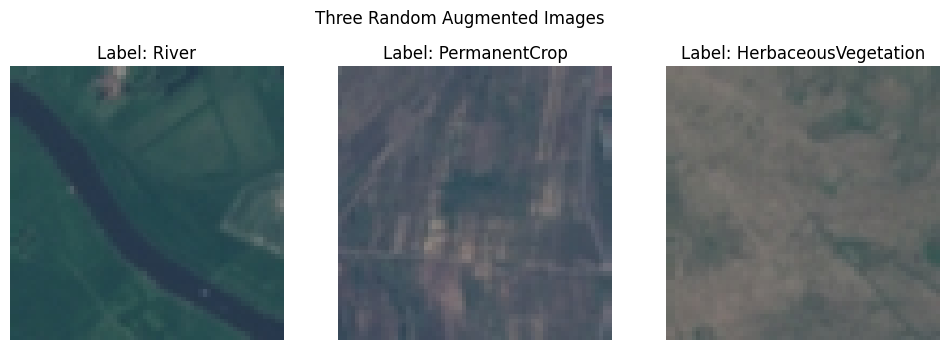

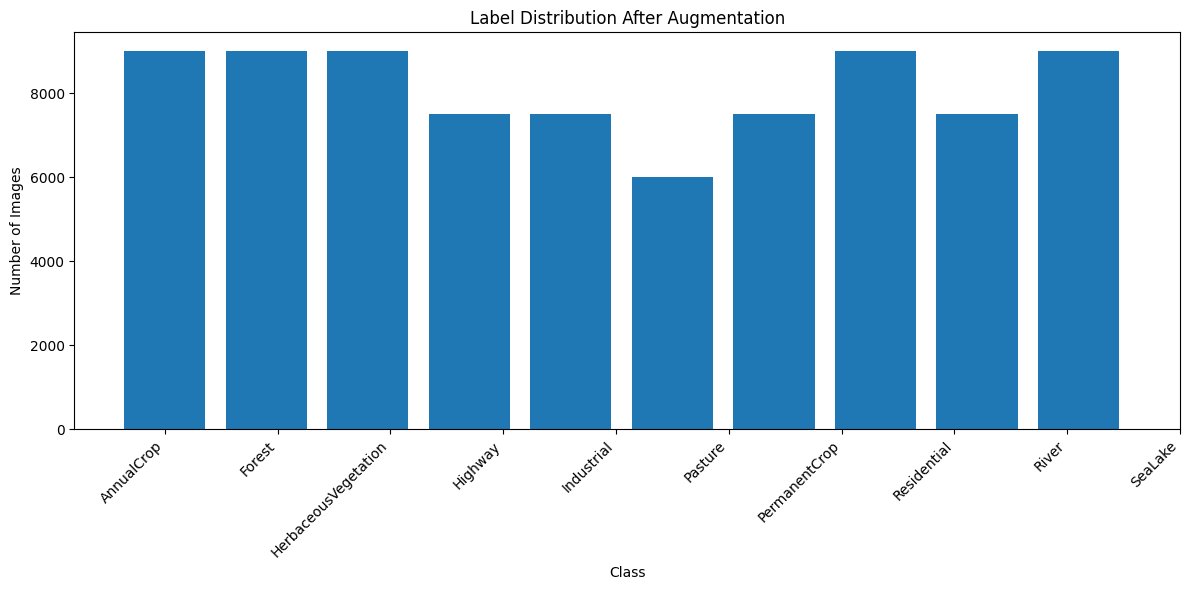

In [13]:
import os
import numpy as np
import random
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed
random.seed(42)

# Define dataset path
dataset_path = r"D:\Course_25Spring\DEEPL\EuroSAT_DeepLearning\EuroSAT/2750"
image_size = (64, 64)  # Standard resize size

# Get class names
class_names = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Function for data augmentation
def augment_image(image):
    augmented_images = []
    
    # 1. Horizontal flip
    flipped = ImageOps.mirror(image)
    augmented_images.append(flipped)
    
    # 2. Random rotation
    angle = random.uniform(-20, 20)
    rotated = image.rotate(angle)
    augmented_images.append(rotated)
    
    return augmented_images

# Initialize arrays
rgb_image_data = []
gray_image_data = []
labels = []

# Load, augment, and flatten images
for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    image_files = [file for file in os.listdir(class_folder) if file.endswith('.jpg') or file.endswith('.png')]
    
    for image_file in image_files:
        image_path = os.path.join(class_folder, image_file)
        image = Image.open(image_path).convert('RGB').resize(image_size)
        
        # Original image
        rgb_array = np.array(image).flatten()
        gray_array = np.array(image.convert('L')).flatten()
        rgb_image_data.append(rgb_array)
        gray_image_data.append(gray_array)
        labels.append(class_to_idx[class_name])
        
        # Augmented images
        augmented_images = augment_image(image)
        for aug_img in augmented_images:
            rgb_aug_array = np.array(aug_img).flatten()
            gray_aug_array = np.array(aug_img.convert('L')).flatten()
            rgb_image_data.append(rgb_aug_array)
            gray_image_data.append(gray_aug_array)
            labels.append(class_to_idx[class_name])

# Convert to numpy arrays
X_rgb = np.array(rgb_image_data)
X_gray = np.array(gray_image_data)
y = np.array(labels)

print(f"Original number of images: {sum([len(os.listdir(os.path.join(dataset_path, c))) for c in class_names])}")
print(f"New dataset size after augmentation: {X_rgb.shape[0]}")

# Plot three random images from the RGB dataset
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    idx = random.randint(0, X_rgb.shape[0]-1)
    img = X_rgb[idx].reshape((64, 64, 3))
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {class_names[y[idx]]}")
    axes[i].axis('off')
plt.suptitle("Three Random Augmented Images")
plt.show()

# Plot histogram of label distribution
plt.figure(figsize=(12, 6))
plt.hist(y, bins=len(class_names), align='left', rwidth=0.8)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right')
plt.title("Label Distribution After Augmentation")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# Optional: Save datasets
np.save('X_rgb_augmented.npy', X_rgb)
np.save('X_gray_augmented.npy', X_gray)
np.save('y_augmented.npy', y)

